In [1]:
import gymnasium as gym
import numpy as np
import numba as nb
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import cv2

2023-05-04 10:52:51.828319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 10:52:53.630908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
@nb.njit(fastmath=True)
def get_action(observation):
    processed_img = np.copy(observation)
    colours = np.array([[170,0,0],[105,230,105],[0,0,0],[101,101,101],[255,255,255]])
    
    # Crop image
    processed_img = processed_img[:-12, 14:-14]
    
    # Change to a high contrast image with uniform colours
    for i, row in enumerate(processed_img):
        for j, pixel in enumerate(row):
            dists = np.empty(len(colours))
            for k, colour in enumerate(colours):
                dist = 0
                for x, y in zip(pixel, colour):
                    dist += np.abs(x-y) ** 2
                dists[k] = dist ** (1/2)
            min_val = dists[0]
            min_ind = 0
            for l in range(1, len(colours)):
                if dists[l] < min_val:
                    min_val = dists[l]
                    min_ind = l
            processed_img[i,j] = colours[min_ind]
            
    # To get steering, count road pixels on the left and right of the car.
    left_line = processed_img[56:57,:34][0]
    right_line = processed_img[56:57,38:][0]
    left_count, right_count = 0, 0
    for left_pixel, right_pixel in zip(left_line, right_line):
        if left_pixel[1] == 101:
            left_count += 1
        if right_pixel[1] == 101:
            right_count += 1
    steering = right_count / len(right_line) - left_count / len(left_line)
    
    # To get gas, count road pixels in front of the car.
    middle_line = processed_img.shape[1] / 2
    front_line = processed_img[:67,middle_line:middle_line+1]
    front_count = 0
    for pixel in front_line:
        if pixel[0, 1] == 101:
            front_count += 1
    front_count_norm = front_count / len(front_line)
    if steering > 0.75:
        gas = front_count_norm * 0.05
    elif steering > 0.5:
        gas = front_count_norm * 0.1
    elif steering > 0.5:
        gas = front_count_norm * 0.25
    else:
        gas = front_count / len(front_line)
        
    # Use gas and steering to get brake
    if (gas > 0.75) and (abs(steering) > 0.75):
        brake = gas * 0.975
    elif (gas > 0.75) and (abs(steering) > 0.5):
        brake = gas * 0.85
    elif (gas > 0.75) and (abs(steering) > 0.25):
        brake = gas * 0.55
    elif (gas > 0.5) and (abs(steering) > 0.75):
        brake = gas * 0.975
    elif (gas > 0.5) and (abs(steering) > 0.5):
        brake = gas * 0.75
    elif (gas > 0.5) and (abs(steering) > 0.25):
        brake = gas * 0.45
    elif (gas > 0.25) and (abs(steering) > 0.75):
        brake = gas * 0.975
    elif (gas > 0.25) and (abs(steering) > 0.5):
        brake = gas * 0.65
    elif (gas > 0.25) and (abs(steering) > 0.25):
        brake = gas * 0.35
    else:
        brake = 0.05
        
    return [steering, 0.5 * gas, brake]

In [3]:
def crop(img):
    img = img[:84, 6:90]
    return img

@nb.njit(fastmath=True)
def rgb_to_grey(img):
    """
    Convert an RGB image to greyscale using the weighted method.
    """
    num_rows, num_cols, _ = img.shape
    grey_img = np.empty((num_rows, num_cols), dtype=np.uint32)
    for i, row in enumerate(img):
        for j, rgb_pixel in enumerate(row):
            # Compute weighted sum of RGB channels
            grey_img[i, j] = 0.2989 * rgb_pixel[0] + 0.5870 * rgb_pixel[1] + 0.1140 * rgb_pixel[2]

    return grey_img

In [4]:
def complete_run(env):
    observation, info = env.reset()
    episode_states = []
    episode_actions = []
    for _ in range(50):
        action = [0.0, 0.0, 0.0]
        observation, reward, terminated, truncated, info = env.step(action)
    steps = 0
    reward_sum = 0
    reward_size = 0
    reward_exp = 936
    while True:
        state_img = np.copy(observation)
        state_img = crop(state_img)
        state_img = rgb_to_grey(state_img).reshape((84,84,1))
        episode_states.append(state_img)
            
        action = get_action(observation)
        episode_actions.append(action)
        
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1
        if reward > 0:
            reward_size = reward
            reward_sum += reward
            reward_exp = -2.128*(reward_size**2) + 20.65*reward_size + 919.0
        if (round(reward_sum) == round(reward_exp)):
            return episode_states, episode_actions
            break
        if steps >= 1500:
            return [], []

In [91]:
states, actions = complete_run(env)

In [5]:
def gen_dataset(length):
    env = gym.make("CarRacing-v2", domain_randomize=False, autoreset=False)
    states = []
    actions = []
    while len(states) < length:
        episode_states, episode_actions = complete_run(env)
        if len(episode_states) > 0:
            states += episode_states
            actions += episode_actions
    return np.array(states), np.array(actions)

In [6]:
states, actions = gen_dataset(25_024)
states_ds = tf.data.Dataset.from_tensor_slices(states) 
actions_ds = tf.data.Dataset.from_tensor_slices(actions) 
dataset = tf.data.Dataset.zip((states_ds, actions_ds))
dataset = dataset.batch(32)
tf.data.Dataset.save(dataset, "./dataset3")

2023-05-03 04:14:12.568572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-03 04:14:12.695110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-03 04:14:12.695177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-03 04:14:12.698990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-03 04:14:12.699061: I tensorflow/compile

In [5]:
dataset = tf.data.Dataset.load("./dataset")

2023-05-04 10:52:58.631675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 10:52:58.845669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 10:52:58.845833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 10:52:58.851368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 10:52:58.851486: I tensorflow/compile

In [6]:
supervised_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=8, strides=4, activation="relu", input_shape=(84,84,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="linear")
])
supervised_model.compile(optimizer="adam", loss="mse")
supervised_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 64)        4160      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20, 20, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 128)         131200    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 128)        512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 9, 9, 128)         0

In [8]:
history = supervised_model.fit(dataset, epochs=15)

Epoch 1/15


2023-05-03 04:14:15.428469: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 724284288 exceeds 10% of free system memory.
2023-05-03 04:14:15.618579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [25662,3]
	 [[{{node Placeholder/_2}}]]
2023-05-03 04:14:16.344667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-03 04:14:18.161026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-03 04:14:21.519045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the 

802/802 [==============================] - 17s 11ms/step - loss: 0.5858
Epoch 2/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0205
Epoch 3/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0183
Epoch 4/15
802/802 [==============================] - 8s 9ms/step - loss: 0.0195
Epoch 5/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0185
Epoch 6/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0190
Epoch 7/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0193
Epoch 8/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0183
Epoch 9/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0175
Epoch 10/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0171
Epoch 11/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0177
Epoch 12/15
802/802 [==============================] - 8s 10ms/step - loss: 0.0155
Epoch 13/15
802/802 [===

In [13]:
guesses = supervised_model.predict(states)

NameError: name 'states' is not defined

In [7]:
supervised_model.load_weights('./checkpoints/my_checkpoint')

In [11]:
supervised_model.save_weights('./checkpoints/my_checkpoint')

In [18]:
env = gym.make("CarRacing-v2", domain_randomize=False, autoreset=False, render_mode='human')
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
for _ in range(50):
    action = [0.0, 0.0, 0.0]
    observation, reward, terminated, truncated, info = env.step(action)
steps = 0
reward_sum = 0
num_rewards = 0
reward_size = 0
reward_exp = 0
total_reward = 0
while True:
    state_img = crop(observation)
    state_img = rgb_to_grey(state_img).reshape((84,84,1))
    action = supervised_model.predict(np.array([state_img,]))[0]
    observation, reward, terminated, truncated, info = env.step(action)
    steps += 1
    total_reward += reward
    if reward > 0:
        reward_size = reward
        reward_sum += reward
        reward_exp = -2.128*(reward_size**2) + 20.65*reward_size + 919.0
    if (round(reward_sum) == round(-2.128*(reward_size**2) + 20.65*reward_size + 919.0)):
        print(round(-2.128*(reward_size**2) + 20.65*reward_size + 919.0,2))
        print(round(reward_sum,2))
        break

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step
963.9
963.92


In [54]:
env = gym.make("CarRacing-v2", domain_randomize=False, autoreset=False, render_mode='human')
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
observation, info = env.reset()
for _ in range(50):
    action = [0.0, 0.0, 0.0]
    observation, reward, terminated, truncated, info = env.step(action)
steps = 0
reward_sum = 0
num_rewards = 0
reward_size = 0
reward_exp = 0
total_reward = 0
while True:
    action = get_action(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    steps += 1
    total_reward += reward
    if reward > 0:
        reward_size = reward
        reward_sum += reward
        reward_exp = -2.128*(reward_size**2) + 20.65*reward_size + 919.0

    if (round(reward_sum) == round(-2.128*(reward_size**2) + 20.65*reward_size + 919.0)):
        print(round(-2.128*(reward_size**2) + 20.65*reward_size + 919.0,2))
        print(round(reward_sum,2))
        break

965.63
965.65


In [52]:
for i in range(2):
    action = get_action(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    steps += 1
    total_reward += reward
    if reward > 0:
        reward_size = reward
        reward_sum += reward
        reward_exp = -2.128*(reward_size**2) + 20.65*reward_size + 919.0

    if (round(reward_sum) == round(-2.128*(reward_size**2) + 20.65*reward_size + 919.0)):
        print(round(-2.128*(reward_size**2) + 20.65*reward_size + 919.0,2))
        print(round(reward_sum,2))
        break

In [40]:
x_vals = np.full(34,56)
left_y_vals = np.array(range(14,48))
right_y_vals = np.array(range(48,82))

y_vals = np.full(67,48)
top_x_vals = np.array(range(0,67))

In [36]:
(96-28)/2

34.0

In [37]:
34+14

48

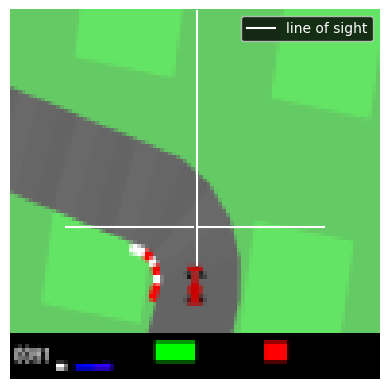

In [53]:
plt.imshow(observation)
plt.plot(left_y_vals, x_vals, color="white")
plt.plot(right_y_vals, x_vals, color="white")
plt.plot(y_vals, top_x_vals, color="white", label="line of sight")
plt.legend(facecolor="black", labelcolor="white")
plt.axis("off")
plt.savefig("pixel_counting.png")
plt.show()
plt.close()